# Imports #

In [33]:
import yfinance as yf
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Getting the data #

In [22]:
#Stock data is the historical stock data until one month ago
stock_data = yf.download('AAPL', start='2020-01-01', end=datetime.date.today() - datetime.timedelta(days=30))
# test_data is the stock data for the previous month
test_data = yf.download('AAPL', start = datetime.date.today() - datetime.timedelta(days=29), end = datetime.date.today())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314888,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970085,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200


In [25]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-17,134.830002,137.289993,134.130005,135.940002,135.732758,63646600
2023-01-18,136.820007,138.610001,135.029999,135.210007,135.003876,69672800
2023-01-19,134.080002,136.250000,133.770004,135.270004,135.063782,58280400
2023-01-20,135.279999,138.020004,134.220001,137.869995,137.659805,79972200
2023-01-23,138.119995,143.320007,137.899994,141.110001,140.894882,81760300


Text(0, 0.5, 'Closing Price')

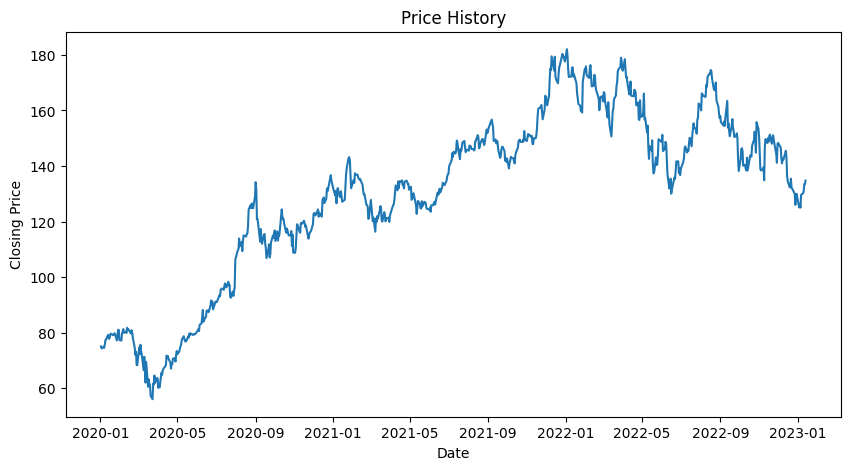

In [26]:
#Visualizing the data
plt.figure(figsize=(10, 5))
plt.title('Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

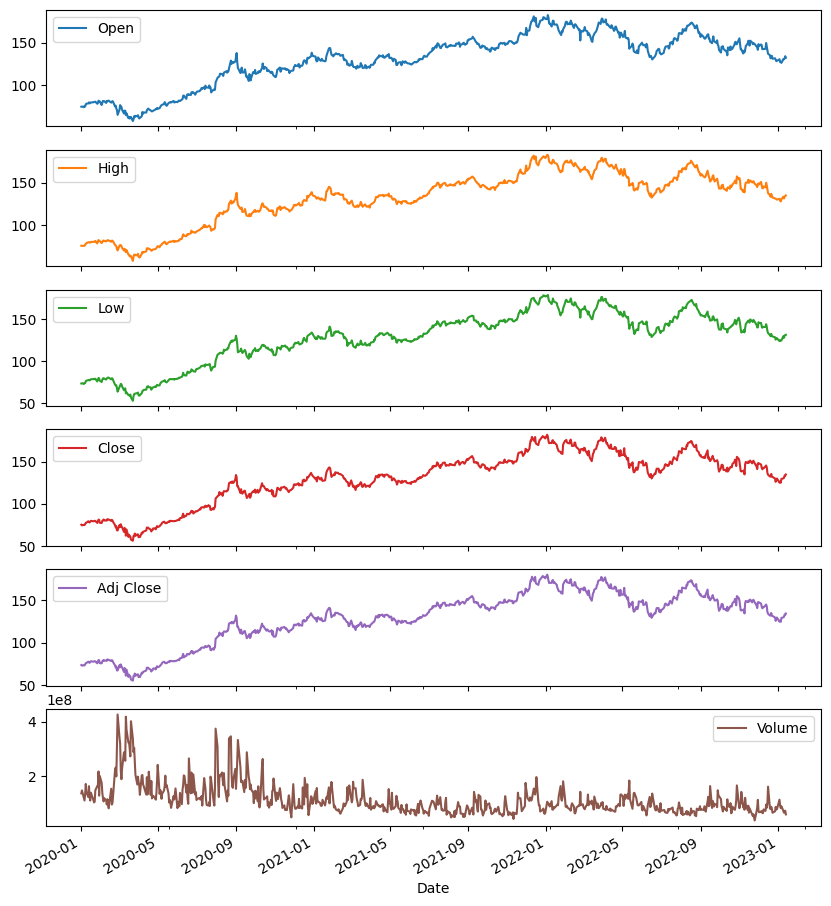

In [31]:
stock_data.plot(subplots=True, figsize=(10, 12))

# Data Preprocessing #

In [32]:
#Scaling the data
sc = MinMaxScaler(feature_range=(-1, 1))
stock_data['Close'] = sc.fit_transform(stock_data['Close'].values.reshape(-1, 1))
stock_data['Close']

Date
2020-01-02   -0.698294
2020-01-03   -0.709889
2020-01-06   -0.700479
2020-01-07   -0.706077
2020-01-08   -0.687017
                ...   
2023-01-09    0.176286
2023-01-10    0.185498
2023-01-11    0.229337
2023-01-12    0.228066
2023-01-13    0.249509
Name: Close, Length: 765, dtype: float64

In [47]:
close_data = stock_data[['Close']]

In [49]:
# convert to numpy array
data_raw = close_data.to_numpy()
data = []
    
# create all possible sequences of length seq_len
for index in range(len(data_raw) - 60): 
    data.append(data_raw[index: index + 60])
    
data = np.array(data)
test_set_size = int(np.round(0.2*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)
    
x_train = data[:train_set_size,:-1,:]
y_train = data[:train_set_size,-1,:]
    
x_test = data[train_set_size:,:-1]
y_test = data[train_set_size:,-1,:]
     

In [50]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (564, 59, 1)
y_train.shape =  (564, 1)
x_test.shape =  (141, 59, 1)
y_test.shape =  (141, 1)


# Model Creation #

In [38]:
import torch
import torch.nn as nn

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [52]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 105

In [53]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [54]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [55]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.19279678165912628
Epoch  1 MSE:  0.15115530788898468
Epoch  2 MSE:  0.10430435836315155
Epoch  3 MSE:  0.05474501848220825
Epoch  4 MSE:  0.012597702443599701
Epoch  5 MSE:  0.03846798092126846
Epoch  6 MSE:  0.03765992447733879
Epoch  7 MSE:  0.016568370163440704
Epoch  8 MSE:  0.0040246788412332535
Epoch  9 MSE:  0.009608136489987373
Epoch  10 MSE:  0.016421852633357048
Epoch  11 MSE:  0.017746273428201675
Epoch  12 MSE:  0.015851717442274094
Epoch  13 MSE:  0.011847816407680511
Epoch  14 MSE:  0.00659592542797327
Epoch  15 MSE:  0.0031803976744413376
Epoch  16 MSE:  0.004472537897527218
Epoch  17 MSE:  0.007754089776426554
Epoch  18 MSE:  0.008766483515501022
Epoch  19 MSE:  0.007838721387088299
Epoch  20 MSE:  0.005564236082136631
Epoch  21 MSE:  0.0032087070867419243
Epoch  22 MSE:  0.0026948226150125265
Epoch  23 MSE:  0.003840083722025156
Epoch  24 MSE:  0.004925986286252737
Epoch  25 MSE:  0.005203461740165949
Epoch  26 MSE:  0.004958390258252621
Epoch  27 MSE: